In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models 
from torchvision.utils import make_grid#
import torchvision
import os
import random
from sklearn.model_selection import train_test_split

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

In [6]:
def build_datasets():

    transform = transforms.Compose([
        transforms.Resize((256,256)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    
    trainset = torchvision.datasets.ImageFolder(root='Breast_cancer_400/train', transform=transform)
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=32,
                                          shuffle=True, num_workers=2)
    validset = torchvision.datasets.ImageFolder(root='Breast_cancer_400/valid', transform=transform)
    validloader = torch.utils.data.DataLoader(validset, batch_size=32,
                                         shuffle=True, num_workers=2)
    testset = torchvision.datasets.ImageFolder(root='Breast_cancer_400/test', transform=transform)
    testloader = torch.utils.data.DataLoader(testset, batch_size=32,
                                         shuffle=False, num_workers=2)

    return trainloader,validloader, testloader

classes = ('Adenosis', 'Ductal_Carcinoma', 'Fibroadenoma', 'Lobular_Carcinoma',
               'Mucinous_Carcinoma', 'Papillary_Carcinoma', 'Phyllodes_tumor', 'Tubular_adenoma')

In [7]:
trainloader,validloader, testloader= build_datasets()

In [8]:
import torch.nn as nn
import torch.nn.functional as F
# define the CNN architecture

class CNN(nn.Module):
    def __init__(self, num_classes: int = 8, dropout: float = 0.5) -> None:
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 96, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(96, 256, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(256, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.maxpool = nn.MaxPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Dropout(p=dropout),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout),
            nn.Linear(4096, 1024),
            nn.ReLU(inplace=True),
            nn.Linear(1024, num_classes),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.features(x)
        x = self.maxpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

net = CNN()
net

CNN(
  (features): Sequential(
    (0): Conv2d(3, 96, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (maxpool): MaxPool2d(kernel_size=(6, 6), stride=(6, 6), padding=0, dilation=1, ceil_mode=False)
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_fea

In [9]:
import torch.optim as optim


criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [6]:
def calculate_accuracy(y_pred, y):
    top_pred = y_pred.argmax(1, keepdim = True)
    correct = top_pred.eq(y.view_as(top_pred)).sum()
    acc = correct.float() / y.shape[0]
    return acc

def train(model, iterator, optimizer, criterion, device):
    epoch_loss = 0
    epoch_acc = 0
    model.train()
    for (x, y) in iterator:
        x = x.to(device)
        y = y.to(device)

        optimizer.zero_grad()

        y_pred = model(x)

        loss = criterion(y_pred, y)

        acc = calculate_accuracy(y_pred, y)

        loss.backward()

        optimizer.step()

        epoch_loss += loss.item()
        epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)

def valid(model,iterator):
    epoch_loss = 0
    epoch_acc = 0

    model.eval()

    for (x, y) in iterator:
        x = x.to(device)
        y = y.to(device)
        y_pred = model(x)
        loss = criterion(y_pred, y)
        acc = calculate_accuracy(y_pred, y)

        epoch_loss += loss.item()
        epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)


def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [7]:
import seaborn as sn
import torch.nn as nn
import torch.nn.functional as F
import time

train_l = []
train_a = []
valid_l = []
valid_a = []

if __name__ == '__main__':

    for epoch in range(100):
        start_time = time.monotonic()
        train_loss, train_acc = train(net, trainloader, optimizer, criterion, device)
        valid_loss, valid_acc = valid(net, validloader)
        
        train_l.append(train_loss)
        train_a.append(train_acc)
        valid_l.append(valid_loss)
        valid_a.append(valid_acc)
        
        end_time = time.monotonic()
        epoch_mins, epoch_secs = epoch_time(start_time, end_time)

        print(f'Epoch: {epoch + 1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
        print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc * 100:.2f}%')
        print(f'\tValid Loss: {valid_loss:.3f} | Valid Acc: {valid_acc * 100:.2f}%')
    print('Finished Training')

    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print('Accuracy of the network test images: %d %%' % (
            100 * correct / total))

Epoch: 01 | Epoch Time: 1m 33s
	Train Loss: 1.799 | Train Acc: 40.52%
	Valid Loss: 1.816 | Valid Acc: 43.50%
Epoch: 02 | Epoch Time: 1m 49s
	Train Loss: 1.676 | Train Acc: 43.53%
	Valid Loss: 1.849 | Valid Acc: 43.59%
Epoch: 03 | Epoch Time: 1m 51s
	Train Loss: 1.627 | Train Acc: 43.68%
	Valid Loss: 1.819 | Valid Acc: 43.50%
Epoch: 04 | Epoch Time: 1m 53s
	Train Loss: 1.622 | Train Acc: 44.47%
	Valid Loss: 1.810 | Valid Acc: 43.86%
Epoch: 05 | Epoch Time: 1m 52s
	Train Loss: 1.588 | Train Acc: 47.77%
	Valid Loss: 1.919 | Valid Acc: 20.33%
Epoch: 06 | Epoch Time: 1m 48s
	Train Loss: 1.530 | Train Acc: 48.35%
	Valid Loss: 1.743 | Valid Acc: 32.78%
Epoch: 07 | Epoch Time: 1m 47s
	Train Loss: 1.455 | Train Acc: 51.44%
	Valid Loss: 1.653 | Valid Acc: 44.51%
Epoch: 08 | Epoch Time: 1m 47s
	Train Loss: 1.413 | Train Acc: 51.80%
	Valid Loss: 1.614 | Valid Acc: 47.71%
Epoch: 09 | Epoch Time: 1m 33s
	Train Loss: 1.226 | Train Acc: 55.46%
	Valid Loss: 1.390 | Valid Acc: 55.77%
Epoch: 10 | Epoch T

In [15]:
print(valid_a)

[0.434981685090851, 0.4358974361157679, 0.434981685090851, 0.43864468886302066, 0.2032967032967033, 0.32783882794799385, 0.44505494505494503, 0.47710622732455915, 0.5576923076923077, 0.5622710624893943, 0.7408424910608229, 0.8104395604395604, 0.8287545789729108, 0.8434065934065934, 0.8653846153846154, 0.8489010989010989, 0.858974359192691, 0.8626373626373627, 0.8461538461538461, 0.8516483516483516, 0.8681318681318682, 0.8543956043956044, 0.8461538461538461, 0.8653846153846154, 0.8653846153846154, 0.8617216119399438, 0.8534798536981855, 0.8598901098901099, 0.8534798536981855, 0.8543956043956044, 0.8626373626373627, 0.8617216119399438, 0.8571428571428571, 0.84798534820368, 0.8516483516483516, 0.8681318681318682, 0.8461538461538461, 0.8434065934065934, 0.8342490844674163, 0.8681318681318682, 0.869963370181702, 0.8516483516483516, 0.8598901098901099, 0.8553113554205213, 0.8452380954564273, 0.8461538461538461, 0.8424908427091745, 0.8424908427091745, 0.8516483516483516, 0.8324175824175825, 0

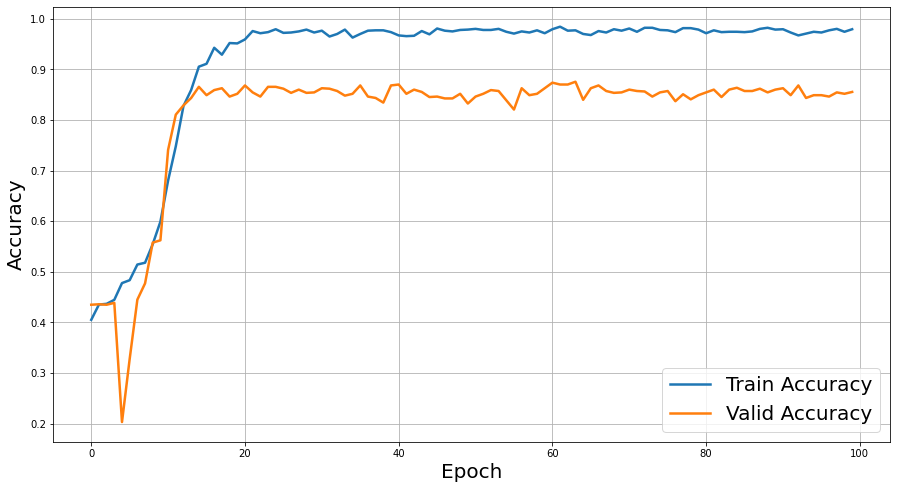

In [9]:
plt.figure(figsize=(15,8))
plt.plot(train_a,label='Train Accuracy',linewidth=2.5)
plt.plot(valid_a,label='Valid Accuracy',linewidth=2.5)
plt.xlabel('Epoch',size=20)
plt.ylabel('Accuracy',size=20)
plt.legend(fontsize = 20)
plt.grid()

In [10]:
classes = ('Adenosis', 'Fibroadenoma', 'Phyllodes_tumor' ,'Tubular_adenoma','Ductal_Carcinoma', 'Lobular_Carcinoma',
               'Mucinous_Carcinoma', 'Papillary_Carcinoma')

# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print("Accuracy for class {:5s} is: {:.1f} %".format(classname,
                                                   accuracy))

Accuracy for class Adenosis is: 71.4 %
Accuracy for class Fibroadenoma is: 92.4 %
Accuracy for class Phyllodes_tumor is: 87.2 %
Accuracy for class Tubular_adenoma is: 77.8 %
Accuracy for class Ductal_Carcinoma is: 81.8 %
Accuracy for class Lobular_Carcinoma is: 78.6 %
Accuracy for class Mucinous_Carcinoma is: 78.3 %
Accuracy for class Papillary_Carcinoma is: 80.8 %


In [11]:
import sklearn

def test_label_predictions(model, device, test_loader):
    model.eval()
    actuals = []
    predictions = []
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            prediction = output.argmax(dim=1, keepdim=True)
            actuals.extend(target.view_as(prediction))
            predictions.extend(prediction)
    return [i.item() for i in actuals], [i.item() for i in predictions]

actuals, predictions = test_label_predictions(net, device, testloader)
print('Confusion matrix:')
print(sklearn.metrics.confusion_matrix(actuals, predictions))
print('F1 score: %f' % sklearn.metrics.f1_score(actuals, predictions, average='micro'))
print('Accuracy score: %f' % sklearn.metrics.accuracy_score(actuals, predictions))

Confusion matrix:
[[ 15   2   0   0   0   1   2   1]
 [  1 146   3   1   0   0   2   5]
 [  1   4  41   0   1   0   0   0]
 [  0   5   0  21   1   0   0   0]
 [  0   4   0   0  27   2   0   0]
 [  0   5   0   0   0  22   0   1]
 [  0   1   1   0   1   2  18   0]
 [  0   3   1   0   1   0   0  21]]
F1 score: 0.856749
Accuracy score: 0.856749


In [10]:
a = [[ 15 ,  2 ,  0 ,  0  , 0 ,  1 ,  2 ,  1],
     [  1 ,146,   3 ,  1 ,  0 ,  0 ,  2   ,5],
     [  1  , 4 , 41 ,  0 ,  1  , 0  , 0  , 0],
     [  0  , 5  , 0 , 21,   1 ,  0  , 0,   0],
     [  0  , 4  , 0   ,0  ,27,   2,   0,   0],
     [  0   ,5 ,  0 ,  0 ,  0 , 22 ,  0  , 1],
     [  0 ,  1,   1 ,  0 ,  1   ,2  ,18 ,  0],
     [  0  , 3  , 1,   0   ,1  , 0,   0,  21]]

b = [[ 15/21,   2/21 ,  0  , 0 ,  0 ,  1/21  , 2/21  , 1/21],
     [  1/158, 146/158 ,  3/158,   1/158 ,  0 ,  0  , 2/158 ,  5/158],
     [  1/47  , 4/47,  41/47,   0 ,  1/47 ,  0 ,  0  , 0],
     [  0  , 5/27,   0  ,21/27 ,  1/27  , 0 ,  0 ,  0],
     [  0  , 4/33 ,  0 ,  0 , 27/33 ,  2/33,   0 ,  0],
     [  0 ,  5/28  , 0   ,0  , 0 , 22/28,   0,   1/28],
     [  0 ,  1/23 ,  1/23 ,  0  , 1/23 ,  2/23,  18/23 ,  0],
     [  0 ,  3/26 ,  1/26,   0 ,  1/26,   0 ,  0 , 21/26]]


c = [[ 18 ,  1 ,  0 ,  1  , 0 ,  1 ,  0 ,  0],
     [  4 ,135,   7 ,  2 ,  1 ,  0 ,  4   ,5],     
     [  0  , 1 , 43 ,  0 ,  2  , 0  , 1  , 0],     
     [  0  , 1  , 0 , 25,   0 ,  0  , 0,   1],    
     [  0  , 1  , 0   ,1  ,30,   0,   0,   1],     
     [  0   ,1 ,  0 ,  0 ,  1 , 26 ,  0  , 0],     
     [  0 ,  1,   0 ,  0 ,  0   ,1  ,21 ,  0],     
     [  0  , 1  , 0,   0   ,1  , 0,   0,  24]]

d = [[ 18/21,   1/21 ,  0  , 1/21 ,  0 ,  1/21  , 0  , 0],     
     [  4/158, 135/158 ,  7/158,   2/158 ,  1/158 ,  0  , 4/158 ,  5/158],     
     [  0/47  , 1/47,  43/47,   0 ,  2/47 ,  0 ,  1/47  , 0],     
     [  0  , 1/27,   0  ,25/27 ,  0/27  , 0 ,  0 ,  1/27],     
     [  0  , 1/33 ,  0 ,  1/33 , 30/33 ,  0,   0 ,  1/33],     
     [  0 ,  1/28  , 0   ,0  , 1/28 , 26/28,   0,   0],     
     [  0 ,  2/23 ,  0 ,  0  , 0 ,  1/23,  20/23 ,  0],     
     [  0 ,  1/26 ,  0,   0 ,  1/26,   0 ,  1/26 , 23/26]]


<AxesSubplot:title={'center':'confusion Matrix x400 ohne Augmentation'}>

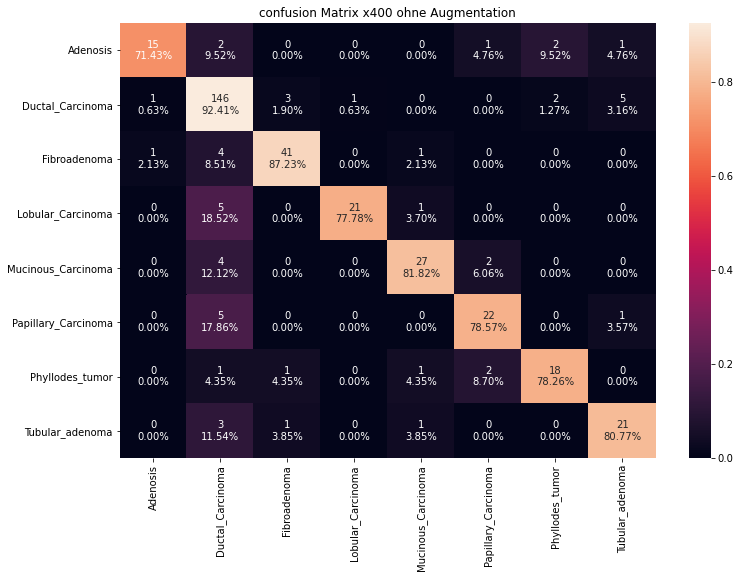

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

group_counts = ["{0:0.0f}".format(value) for value in
                np.array(a).flatten()]

group_percentages = ["{0:.2%}".format(value) for value in
                     np.array(b).flatten()]

labels = [f"{v1}\n{v2}" for v1, v2 in
          zip(group_counts,group_percentages)]

labels = np.asarray(labels).reshape(8,8)

categories = ['Adenosis', 'Ductal_Carcinoma', 'Fibroadenoma', 'Lobular_Carcinoma',
               'Mucinous_Carcinoma', 'Papillary_Carcinoma', 'Phyllodes_tumor', 'Tubular_adenoma']

plt.figure(figsize = (12,8))
plt.title('confusion Matrix x400 ohne Augmentation')
sns.heatmap(b, annot = labels, fmt='', xticklabels = categories, yticklabels = categories)



<AxesSubplot:title={'center':'confusion Matrix x400 mit Data Augmentation'}>

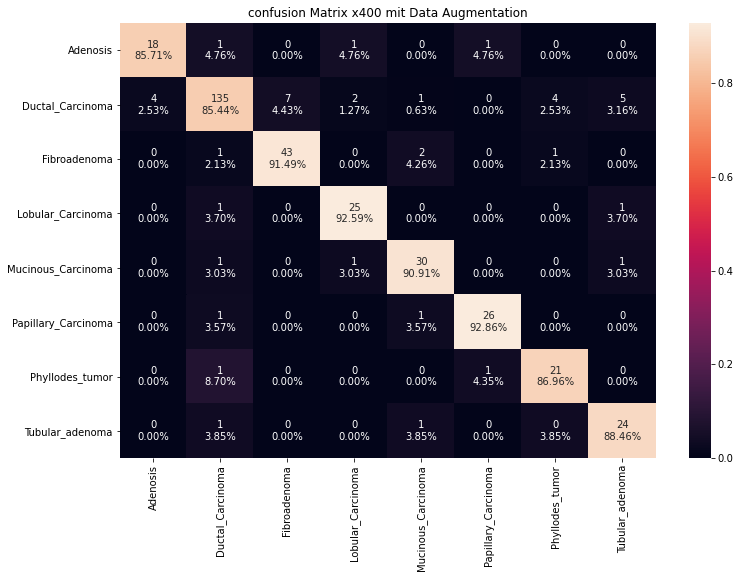

In [14]:
group_counts = ["{0:0.0f}".format(value) for value in
                np.array(c).flatten()]

group_percentages = ["{0:.2%}".format(value) for value in
                     np.array(d).flatten()]

labels = [f"{v1}\n{v2}" for v1, v2 in
          zip(group_counts,group_percentages)]

labels = np.asarray(labels).reshape(8,8)

categories = ['Adenosis', 'Ductal_Carcinoma', 'Fibroadenoma', 'Lobular_Carcinoma',
               'Mucinous_Carcinoma', 'Papillary_Carcinoma', 'Phyllodes_tumor', 'Tubular_adenoma']

plt.figure(figsize = (12,8))
plt.title('confusion Matrix x400 mit Data Augmentation')
sns.heatmap(d, annot = labels, fmt='', xticklabels = categories, yticklabels = categories)



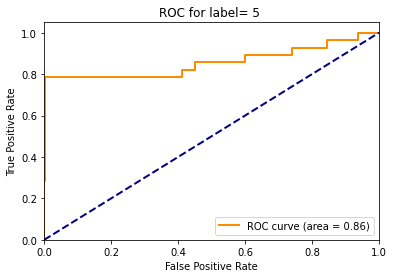

In [19]:
def test_class_probabilities(model, device, test_loader, which_class):
    model.eval()
    actuals = []
    probabilities = []
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            prediction = output.argmax(dim=1, keepdim=True)
            actuals.extend(target.view_as(prediction) == which_class)
            probabilities.extend(np.exp(output[:, which_class]))
    return [i.item() for i in actuals], [i.item() for i in probabilities]

which_class = 5
actuals, class_probabilities = test_class_probabilities(net, device, testloader, which_class)

fpr, tpr, _ = sklearn.metrics.roc_curve(actuals, class_probabilities)
roc_auc = sklearn.metrics.auc(fpr, tpr)
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC for label= %d ' % which_class)
plt.legend(loc="lower right")
plt.show()